## Import

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from cdd import CDD


In [3]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')

In [4]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

## DAR

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 256)
        self.relu = nn.ELU()
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 256)
        self.h4 = nn.Linear(256,256)
        self.reg = nn.Linear(256, 1)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        
        
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop1(h1_x)
        h1_x = self.h4(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop2(h1_x)
        h1_x = self.reg(h1_x)

        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h4(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}

### Pretrained

In [26]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_loss = 1000
train_idx = random.sample(range(len(x_s)), len(x_s)//5*4)
val_idx = list(set(list(range(len(x_s)))) - set(train_idx))
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()

    model_output_s = model.output(x_s[train_idx])
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']



    # mse loss
    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s[train_idx])
    y_s_mse.backward()
    optimizer.step()
    
    model.eval()
    model_output_s = model.output(x_s[val_idx])
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']
    val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s[val_idx])
    
    if best_loss > val_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        print(f"Saving... val mse{val_loss}")
        torch.save(best_model, "best_pretrained_model.pt")

Saving... val mse7.443878650665283
Saving... val mse0.7711961269378662
Saving... val mse0.7641507387161255
Saving... val mse0.6047084331512451
Saving... val mse0.5467944741249084
Saving... val mse0.5405303835868835
Saving... val mse0.5323477983474731
Saving... val mse0.5152057409286499
Saving... val mse0.5117090344429016
Saving... val mse0.5107713341712952
Saving... val mse0.5061712861061096
Saving... val mse0.5036850571632385
Saving... val mse0.502633810043335
Saving... val mse0.4994213879108429
Saving... val mse0.49836114048957825
Saving... val mse0.49780234694480896
Saving... val mse0.49742352962493896
Saving... val mse0.49729862809181213
Saving... val mse0.49412739276885986
Saving... val mse0.4922540783882141
Saving... val mse0.4912668764591217
Saving... val mse0.49096134305000305
Saving... val mse0.4886699616909027
Saving... val mse0.4856998324394226
Saving... val mse0.4833826720714569
Saving... val mse0.4817790687084198
Saving... val mse0.4808080792427063
Saving... val mse0.48042

KeyboardInterrupt: 

### DA

In [27]:
model = torch.load("best_pretrained_model.pt")
model.eval()
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

model_output_t_labeled = model.output(x_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

model_output_t = model.output(x_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")

source mse : 0.009627632796764374, labeled target mse : 1.9264698028564453, target mse : 1.9639837741851807


In [12]:
class MELU(torch.nn.Module): # alpha(max(0,x) + min(1,exp(x)))
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(MELU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.zeros(self.weights.shape)
        monotonic_weights[self.weights >= 0] = self.weights[self.weights >= 0]
        monotonic_weights[self.weights < 0] = torch.exp(self.weights[self.weights < 0])
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'


In [13]:
class MELU_ELU_NN(nn.Module):
    def __init__(self):
        super(MELU_ELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 16
        hidden_sizes = [self._num_units] + [16,16]
        layers = []
        layers.append(MELU(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(MELU(in_features, out_features))
        layers.append(MELU(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
        
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ELU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ELU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ELU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ELU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ELU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ELU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

    def output(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ELU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ELU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ELU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ELU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ELU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ELU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        output1 = outputs
        outputs = self.model[-1](outputs)
        return {'f_x':output1, 'output':outputs}

In [14]:
mapper = MELU_ELU_NN()
optimizer = optim.Adam(mapper.parameters(), lr=0.01)
best_mapper = copy.deepcopy(mapper)
best_loss = 1000
loss_list = []
bn = len(x_t_labeled)
for epoch in range(20000):
    optimizer.zero_grad()

    latent_x_s = x_s
    
    mapper_output_t_labeled = mapper.output(x_t_labeled)
    latent_x_t_labeled = mapper_output_t_labeled['output']
    
    
    # source latent에서 batch 추출
    batch_latent_x_s_index = torch.randperm(latent_x_s.size(0))[:bn]
    batch_latent_x_s = latent_x_s[batch_latent_x_s_index]


    # cdd loss
    feats_toalign_S = [batch_latent_x_s, torch.tensor([1]).repeat(len(batch_latent_x_s),1)]
    feats_toalign_T = [latent_x_t_labeled, torch.tensor([1]).repeat(len(latent_x_t_labeled),1)]
    cdd = CDD(kernel_num=(10,10), kernel_mul=(2,2), num_layers=2, num_classes=1, intra_only=True)
    cdd_loss = cdd.forward(feats_toalign_S, feats_toalign_T, [bn], [bn])['cdd']

    # ns loss
    epsilon_k = 5

    f_s_vector = latent_x_s
    f_t_vector = latent_x_t_labeled

    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=epsilon_k)
    knn.fit(y_s, np.array(range(len(y_s))))
    total_ns_loss = 0
    for i in range(bn):
        best_dist = 1000
        error = 0
        neighbors = knn.kneighbors(y_t_labeled[i].reshape(-1,1))[1][0].tolist()
        for index_i in neighbors:
            temp_f_dist = torch.abs(f_t_vector[i] - f_s_vector[index_i]).norm()
            temp_y_dist = torch.abs(y_t_labeled[i] - y_s[index_i]).norm()
            if best_dist > temp_f_dist + temp_y_dist:
                best_dist = temp_f_dist + temp_y_dist
                error = temp_f_dist
        total_ns_loss += error
    ns_loss = total_ns_loss / bn

    total_loss = cdd_loss + ns_loss
    
    if best_loss > total_loss:
        best_loss = total_loss
        best_mapper = copy.deepcopy(mapper)
    total_loss.backward()

    loss_list.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch : {epoch}, total_loss = {np.mean(np.array(loss_list))}")
        loss_list = []
    optimizer.step()

Epoch : 0, total_loss = 403.3511047363281
Epoch : 100, total_loss = 272.9623114013672
Epoch : 200, total_loss = 65.96550497055054
Epoch : 300, total_loss = 16.709600811004638
Epoch : 400, total_loss = 5.056667976379394
Epoch : 500, total_loss = 3.45528821349144
Epoch : 600, total_loss = 2.533423818349838
Epoch : 700, total_loss = 2.0599081206321714
Epoch : 800, total_loss = 1.4935596895217895
Epoch : 900, total_loss = 1.0643555051088334
Epoch : 1000, total_loss = 1.0597199946641922
Epoch : 1100, total_loss = 1.0020693337917328
Epoch : 1200, total_loss = 1.022824844121933
Epoch : 1300, total_loss = 1.045545278787613
Epoch : 1400, total_loss = 0.9616743969917297
Epoch : 1500, total_loss = 1.0054955768585205
Epoch : 1600, total_loss = 1.0012310475111008
Epoch : 1700, total_loss = 1.003614126443863
Epoch : 1800, total_loss = 0.9722830265760422
Epoch : 1900, total_loss = 0.9694455868005752
Epoch : 2000, total_loss = 1.0254874062538146
Epoch : 2100, total_loss = 1.0750894117355347
Epoch : 22

KeyboardInterrupt: 

In [26]:
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

f_t_labeled = best_mapper.output(x_t_labeled)['output']
model_output_t_labeled = model.output(f_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

f_t = best_mapper.output(x_t)['output']
model_output_t = model.output(f_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_true_mse}")

source mse : 0.0011723603820428252, labeled target mse : 0.0923101007938385, target mse : 0.08201545476913452


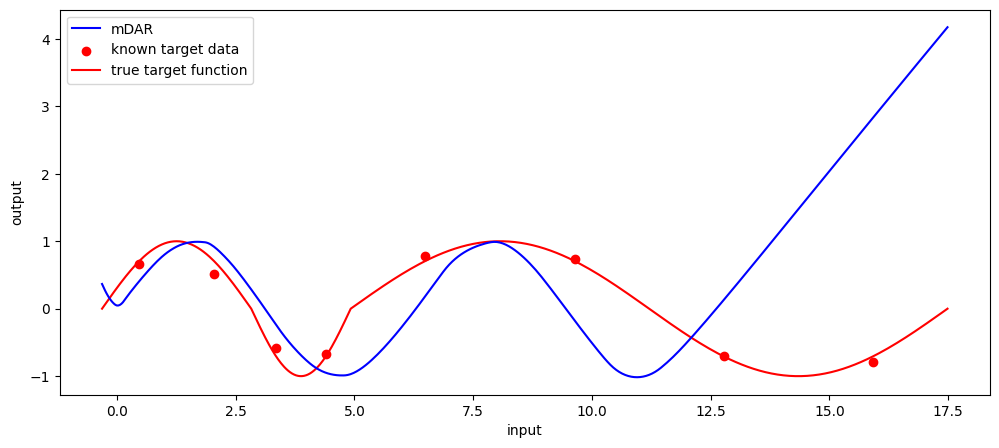

In [28]:
plt.figure(figsize=(12,5))
plt.plot(x_t, y_t_hat.detach().numpy(), c='blue', label='mDAR', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()

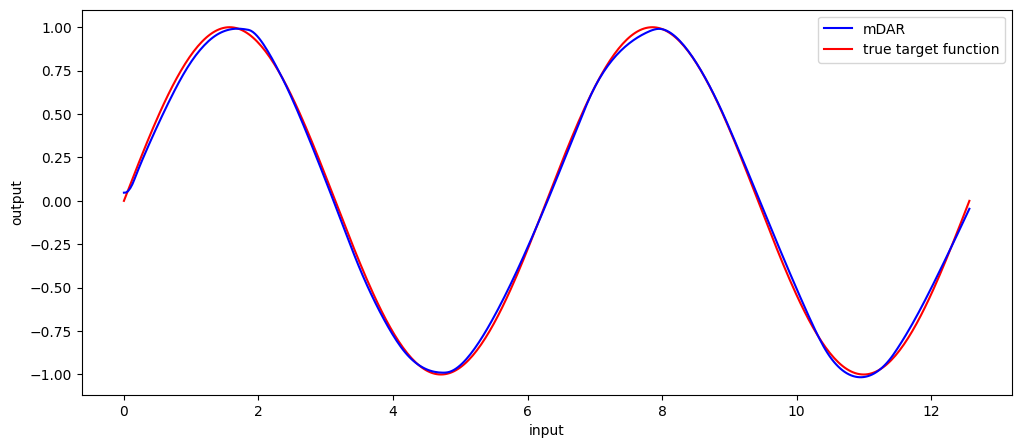

In [29]:
plt.figure(figsize=(12,5))
plt.plot(x_s, y_s_hat.detach().numpy(), c='blue', label='mDAR', zorder=2)
plt.plot(x_s, y_s_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()